# Iot Task Dataset Generation

**IoT with Tasks**

In [44]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from math import radians, cos, sin, asin, sqrt
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of IoT devices and tasks
total_tasks = 5000

# Base timestamp
base_time = datetime(2025, 1, 1, 0, 0, 0)

# Dhaka base GPS coordinates (reference point for distance)
base_lat = 23.8103
base_lon = 90.4125

# Define 10 different area centers in Dhaka
area_centers = [
    # Area 1: Jatrabari
    (23.7460, 90.4345),
    # Area 2: Dhanmondi
    (23.7465, 90.3716),
    # Area 3: Gulshan
    (23.7800, 90.4167),
    # Area 4: Azimpur
    (23.7250, 90.3850),
    # Area 5: Uttara
    (23.8750, 90.3833),
    # Area 6: Mirpur
    (23.8050, 90.3583),
    # Area 7: Motijheel
    (23.7333, 90.4167),
    # Area 8: Lalmatia
    (23.7600, 90.3667),
    # Area 9: Banani
    (23.7900, 90.4067),
    # Area 10: Mohammadpur
    (23.7633, 90.3583)
]

# Generate IoT devices
cluster_std = 0.0015  # Spread for each cluster
iot_devices = []
device_counter = 0

# Create devices in each cluster
for cluster_idx, center in enumerate(area_centers):
    # Determine number of devices in this cluster (40-60)
    num_devices = np.random.randint(40, 61)

    # Create devices with their locations
    for i in range(num_devices):
        lat = center[0] + np.random.normal(0, cluster_std)
        lon = center[1] + np.random.normal(0, cluster_std)

        # Determine tasks per device (7-10)
        num_tasks = np.random.randint(7, 11)

        iot_devices.append({
            'iot_id': f"D{device_counter}",
            'cluster_id': cluster_idx,
            'Location_Lat': lat,
            'Location_Lon': lon,
            'num_tasks': num_tasks
        })
        device_counter += 1

# Calculate total tasks
total_generated_tasks = sum(device['num_tasks'] for device in iot_devices)

# Adjust to exactly 5000 tasks
task_diff = total_generated_tasks - total_tasks
if task_diff != 0:
    # If we have too many tasks
    if task_diff > 0:
        # Get indices of devices sorted by task count (descending)
        sorted_indices = sorted(range(len(iot_devices)),
                              key=lambda i: iot_devices[i]['num_tasks'],
                              reverse=True)
        for idx in sorted_indices:
            if task_diff <= 0:
                break
            reduction = min(iot_devices[idx]['num_tasks'] - 1, task_diff)
            iot_devices[idx]['num_tasks'] -= reduction
            task_diff -= reduction

    # If we have too few tasks
    else:
        task_diff = abs(task_diff)
        # Get indices of devices sorted by task count (ascending)
        sorted_indices = sorted(range(len(iot_devices)),
                              key=lambda i: iot_devices[i]['num_tasks'])
        while task_diff > 0:
            for idx in sorted_indices:
                if task_diff <= 0:
                    break
                iot_devices[idx]['num_tasks'] += 1
                task_diff -= 1

# Generate tasks from IoT devices in sequential order
tasks = []

# Generate devices in sequential order (D0, D1, D2...)
for device in sorted(iot_devices, key=lambda x: int(x['iot_id'][1:])):
    iot_id = device['iot_id']
    lat = device['Location_Lat']
    lon = device['Location_Lon']

    # Generate tasks for this device
    for _ in range(device['num_tasks']):
        # Generate task type and size
        task_type = np.random.choice(['Sensor', 'Video', 'AI'])
        if task_type == 'Sensor':
            task_size = np.round(np.random.uniform(10, 100), 2)
        elif task_type == 'Video':
            task_size = np.round(np.random.uniform(200, 500), 2)
        else:  # AI
            task_size = np.round(np.random.uniform(50, 200), 2)

        # Generate CPU attributes
        cpu_frequency_GHz = np.round(np.random.uniform(0.1, 2.0), 2)
        cpu_cycles_per_bit = np.round(1e3 / cpu_frequency_GHz * np.random.uniform(80, 120), 2)
        ipc = np.round(np.random.uniform(0.5, 2.5), 2)
        capability_MIPS = np.round(cpu_frequency_GHz * 1000 * ipc, 2)

        # Generate other attributes
        time_offset = timedelta(seconds=np.random.randint(0, 86400))

        tasks.append({
            'iot_id': iot_id,
            'task_type': task_type,
            'task_size_MB': task_size,
            'task_gen_time': base_time + time_offset,
            'cpu_frequency_GHz': cpu_frequency_GHz,
            'cpu_cycles_per_bit': cpu_cycles_per_bit,
            'IPC': ipc,
            'capability_MIPS': capability_MIPS,
            'delay_deadline_ms': np.random.randint(200, 2001),
            'energy_available_mAh': np.round(np.random.uniform(200, 3000), 2),
            'Battery_Level_%': np.round(np.random.uniform(20, 100), 1),
            'Vibration_G': np.round(np.abs(np.random.normal(0, 2)), 2),
            'Signal_Strength_dBm': float(np.random.randint(-100, -50)),
            'task_priority_score': np.round(np.random.uniform(0.1, 1.0), 2),
            'Location_Lat': lat,
            'Location_Lon': lon
        })

# Create DataFrame
iot_df = pd.DataFrame(tasks)

# Calculate distances using haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

iot_df['distance_m'] = iot_df.apply(
    lambda row: haversine(base_lat, base_lon, row['Location_Lat'], row['Location_Lon']),
    axis=1
)

# Path loss model
frequency_Hz = 2.4e9
c = 3e8
wavelength = c / frequency_Hz
d0 = 1.0
path_loss_exponent = 3.5

def path_loss(d):
    d = d if d >= d0 else d0
    PL_d0 = 20 * np.log10(4 * np.pi * d0 / wavelength)
    return PL_d0 + 10 * path_loss_exponent * np.log10(d / d0)

# Calculate channel-dependent features
iot_df['channel_gain_dB'] = -iot_df['distance_m'].apply(path_loss) + np.random.normal(0, 2, len(iot_df))

# SNR and uplink data rate
iot_df['bandwidth_MHz'] = np.random.uniform(1.0, 10.0, len(iot_df))
snr_linear = np.maximum(10 ** (iot_df['channel_gain_dB'] / 10), 0.01)
iot_df['uplink_data_rate_Mbps'] = iot_df['bandwidth_MHz'] * np.log2(1 + snr_linear)
iot_df['uplink_data_rate_Mbps'] = np.round(iot_df['uplink_data_rate_Mbps'], 4)

# Apply minimum rate floor
min_rate_floor = np.random.uniform(0.05, 0.5, len(iot_df))
iot_df['uplink_data_rate_Mbps'] = np.where(
    iot_df['uplink_data_rate_Mbps'] < min_rate_floor,
    min_rate_floor,
    iot_df['uplink_data_rate_Mbps']
)

# Uplink power transfer
iot_df['uplink_power_transfer_mW'] = 100 + iot_df['uplink_data_rate_Mbps'] * 50 + np.random.normal(0, 10, len(iot_df))
iot_df['uplink_power_transfer_mW'] = np.round(iot_df['uplink_power_transfer_mW'], 2)
iot_df['uplink_power_transfer_mW'] = np.clip(iot_df['uplink_power_transfer_mW'], 50, None)

# Offload ratio
max_rate = iot_df['uplink_data_rate_Mbps'].max()
normalized_rate = iot_df['uplink_data_rate_Mbps'] / max_rate
normalized_size = iot_df['task_size_MB'] / iot_df['task_size_MB'].max()
offload_base = 0.3 + 0.7 * (normalized_rate * 0.7 + normalized_size * 0.3)
#iot_df['offload_ratio'] = np.clip(offload_base, 0.2, 1.0)
#iot_df['offload_ratio'] = np.round(iot_df['offload_ratio'], 2)

# Energy deadline
task_size_bits = iot_df['task_size_MB'] * 8 * 1e6
energy_per_cycle = 1e-9
iot_df['energy_deadline_mJ'] = np.round(
    (task_size_bits * iot_df['cpu_cycles_per_bit'] * energy_per_cycle) / 1e-3,
    2
)

# Add anomalies to 5% of data
anomaly_mask = np.random.rand(len(iot_df)) < 0.05
anomaly_indices = iot_df.index[anomaly_mask]

# Signal strength anomaly
signal_anomalies = np.random.choice([1, 2], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'Signal_Strength_dBm'] = np.where(
    signal_anomalies == 1,
    iot_df.loc[anomaly_indices, 'Signal_Strength_dBm'] + np.random.uniform(10, 20, size=anomaly_mask.sum()),
    iot_df.loc[anomaly_indices, 'Signal_Strength_dBm'] - np.random.uniform(10, 20, size=anomaly_mask.sum())
)

# Vibration anomaly
iot_df.loc[anomaly_indices, 'Vibration_G'] = np.random.uniform(5, 15, size=anomaly_mask.sum())

# Task size anomaly
size_anomalies = np.random.choice([0.05, 3.0], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'task_size_MB'] = iot_df.loc[anomaly_indices, 'task_size_MB'] * size_anomalies

# CPU frequency anomaly
cpu_anomalies = np.random.choice([0.01, 5.0], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'cpu_frequency_GHz'] = cpu_anomalies

# Energy available anomaly
energy_anomalies = np.random.choice([0.05, 3.0], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'energy_available_mAh'] = iot_df.loc[anomaly_indices, 'energy_available_mAh'] * energy_anomalies

# Deadline anomaly
deadline_anomalies = np.random.choice([50, 10000], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'delay_deadline_ms'] = deadline_anomalies

# Create shuffled task IDs
task_ids = [f"T{i+1}" for i in range(len(iot_df))]
random.shuffle(task_ids)
iot_df['task_id'] = task_ids

# Reorder columns to have task_id first
cols = ['task_id'] + [col for col in iot_df.columns if col != 'task_id']
iot_df = iot_df[cols]

# Save the dataset
iot_df.to_csv("Final_iot_capabilities_dataset.csv", index=False)
print("Dataset generated and saved as 'Final_GLEMATO_clustered_iot_dataset.csv'")
print(f"Total IoT devices: {len(iot_devices)}")
print(f"Total tasks: {len(iot_df)}")

Dataset generated and saved as 'Final_GLEMATO_clustered_iot_dataset.csv'
Total IoT devices: 527
Total tasks: 5000


**Dataset Summary**

In [5]:
iot_df

,task_id,iot_id,task_type,task_size_MB,task_gen_time,cpu_frequency_GHz,cpu_cycles_per_bit,IPC,capability_MIPS,delay_deadline_ms,...,Signal_Strength_dBm,task_priority_score,Location_Lat,Location_Lon,distance_m,channel_gain_dB,bandwidth_MHz,uplink_data_rate_Mbps,uplink_power_transfer_mW,energy_deadline_mJ
0,T1384,D0,Sensor,85.78,2025-01-01 01:21:35,1.09,96278.37,0.68,741.2,1384,...,-56.000000,0.42,23.745175,90.435273,7603.343224,-177.360952,1.605184,0.361831,107.68,6.607007e+07
1,T1882,D0,Sensor,41.17,2025-01-01 11:51:25,0.55,182525.40,2.15,1182.5,1630,...,-95.000000,0.93,23.745175,90.435273,7603.343224,-176.884283,3.715832,0.489047,116.43,6.011657e+07
2,T4902,D0,AI,136.19,2025-01-01 03:25:29,1.18,81052.30,1.50,1770.0,877,...,-87.000000,0.17,23.745175,90.435273,7603.343224,-177.420809,6.860371,0.118069,113.38,8.830810e+07
3,T1525,D0,Sensor,36.18,2025-01-01 15:20:49,5.00,228063.02,2.41,939.9,10000,...,-50.132338,0.93,23.745175,90.435273,7603.343224,-178.926775,7.939530,0.499231,123.38,2.200352e+07
4,T4655,D0,Video,241.76,2025-01-01 09:48:18,1.81,62526.68,1.14,2063.4,1101,...,-69.000000,0.63,23.745175,90.435273,7603.343224,-173.746921,8.356422,0.374544,107.42,1.209316e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,T1829,D526,Video,495.89,2025-01-01 06:22:21,1.96,58465.91,0.68,1332.8,1132,...,-88.000000,0.72,23.761662,90.357825,7758.782952,-177.028539,6.080571,0.305371,123.75,2.319413e+08
4996,T2007,D526,Video,454.43,2025-01-01 15:01:10,1.13,89721.06,1.87,2113.1,376,...,-63.000000,0.62,23.761662,90.357825,7758.782952,-174.919964,5.241925,0.123150,104.62,3.261755e+08
4997,T2254,D526,Video,228.03,2025-01-01 19:16:50,1.83,57288.97,2.48,4538.4,578,...,-71.000000,0.34,23.761662,90.357825,7758.782952,-174.924122,8.283379,0.272213,131.44,1.045088e+08
4998,T205,D526,AI,145.10,2025-01-01 23:49:53,0.80,113652.88,2.49,1992.0,1414,...,-69.000000,0.96,23.761662,90.357825,7758.782952,-178.181654,3.833940,0.268111,98.44,1.319283e+08


In [6]:
# How many tasks have each iot_id devices, check it.

# Group by 'iot_id' and count the number of tasks for each device
task_counts_per_device = iot_df['iot_id'].value_counts()

# Print the result
print("\nNumber of tasks per IoT device:")
task_counts_per_device


Number of tasks per IoT device:


,count
iot_id,
D506,11
D14,11
D501,11
D0,11
D19,11
...,...
D42,8
D45,8
D505,8


In [7]:
# calculate how many task.

# The number of tasks is simply the number of rows in the DataFrame
task_id = len(iot_df)

print(f"\nTotal number of tasks: {task_id}")


Total number of tasks: 5000


**IoT devices Task Cluster Analysis**

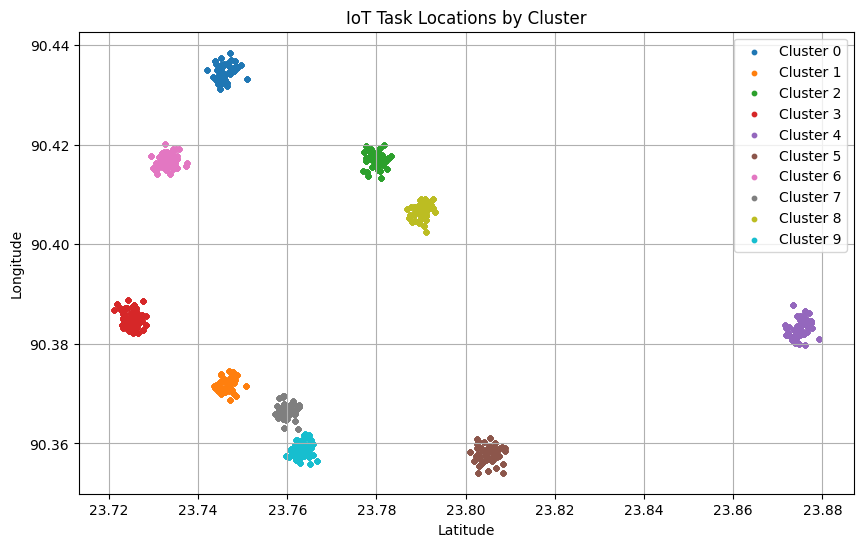

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract iot_id and cluster_id from iot_devices and create a temporary DataFrame
device_cluster_info = pd.DataFrame([{'iot_id': device['iot_id'], 'cluster_id': device['cluster_id']} for device in iot_devices])

# Drop 'cluster_id' from iot_df if it already exists to prevent merge errors on re-execution
if 'cluster_id' in iot_df.columns:
    iot_df = iot_df.drop(columns=['cluster_id'])

# Merge the cluster_id into iot_df
iot_df = pd.merge(iot_df, device_cluster_info, on='iot_id', how='left')

plt.figure(figsize=(10, 6))
for cluster_id in sorted(set(iot_df['cluster_id'])):
    subset = iot_df[iot_df['cluster_id'] == cluster_id]
    plt.scatter(subset['Location_Lat'], subset['Location_Lon'], label=f"Cluster {cluster_id}", s=10)
plt.title("IoT Task Locations by Cluster")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='Location_Lat', ylabel='Location_Lon'>

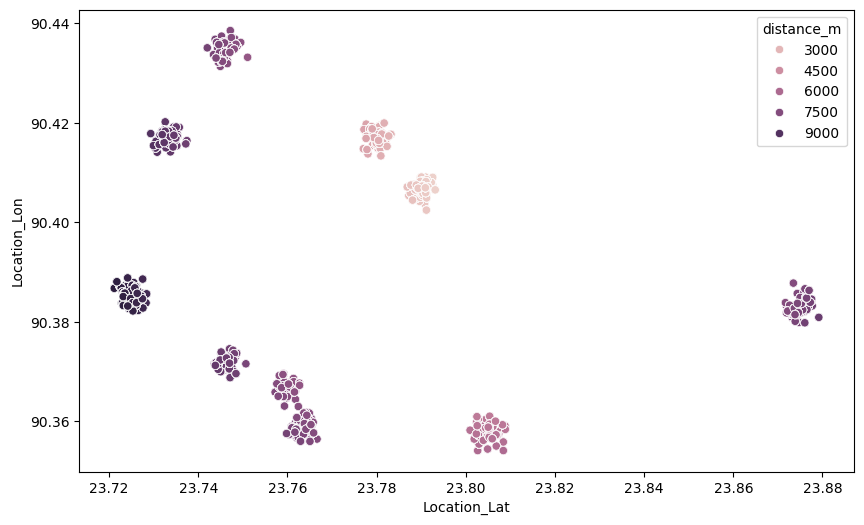

In [9]:
import seaborn as sns

#1. Scatterplot: (Numerical-Numerical) on mutiple features
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Location_Lat", y="Location_Lon", data=iot_df, hue='distance_m')

**Cluster Centroid Information**

In [10]:
# Can you show me the every cluster centroid?

print("Cluster Centroids (Location_Lat, Location_Lon):")
for center in area_centers:
    print(center) # Indent and use print() to display the centroid

Cluster Centroids (Location_Lat, Location_Lon):
(23.746, 90.4345)
(23.7465, 90.3716)
(23.78, 90.4167)
(23.725, 90.385)
(23.875, 90.3833)
(23.805, 90.3583)
(23.7333, 90.4167)
(23.76, 90.3667)
(23.79, 90.4067)
(23.7633, 90.3583)


# Drive Folder Access for Dataset Consolidation

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!pwd

/content


In [13]:
!ls

drive					 Final_UAV_Capability_Dataset.csv
Final_GLEMATO_clustered_iot_dataset.csv  sample_data


In [14]:
from google.colab import auth

auth.authenticate_user()

In [15]:
import os
os.chdir('/content/drive/MyDrive/GLEMATO/Sami/Updated')

In [16]:
!ls

'Copy of Final_IoT_UAV_Grapgh.ipynb'
 Final_GLEMATO_clustered_iot_dataset.csv
 Final_IoT_UAV_Grapgh.ipynb
 FINAL_MHA_GTrXL_LOSS.ipynb
 GLEMETA_MADDPG_Final_IoT_MEC_UAV_Dataset.csv
 GTrXL_task_id_priority_score.csv
 IoT_Dataset_Creation_Final.ipynb
 IoT_UAV_Merged_FullDataset.csv
 merged_iot_priority_dataset.csv
 New_Graph_Generation_IOT_UAV_TASK_Generation.ipynb


# Merge The Two Datasets (GTrXL Task Priority Scores on IoT Task Dataset)

**Load IoT dataset**

In [45]:
loaded_df = pd.read_csv('Final_iot_capabilities_dataset.csv')
print("Dataset loaded successfully!")
loaded_df.head()

Dataset loaded successfully!


,task_id,iot_id,task_type,task_size_MB,task_gen_time,cpu_frequency_GHz,cpu_cycles_per_bit,IPC,capability_MIPS,delay_deadline_ms,...,Signal_Strength_dBm,task_priority_score,Location_Lat,Location_Lon,distance_m,channel_gain_dB,bandwidth_MHz,uplink_data_rate_Mbps,uplink_power_transfer_mW,energy_deadline_mJ
0,T1384,D0,Sensor,85.78,2025-01-01 01:21:35,1.09,96278.37,0.68,741.2,1384,...,-56.000000,0.42,23.745175,90.435273,7603.343224,-177.360952,1.605184,0.361831,107.68,6.607007e+07
1,T1882,D0,Sensor,41.17,2025-01-01 11:51:25,0.55,182525.40,2.15,1182.5,1630,...,-95.000000,0.93,23.745175,90.435273,7603.343224,-176.884283,3.715832,0.489047,116.43,6.011657e+07
2,T4902,D0,AI,136.19,2025-01-01 03:25:29,1.18,81052.30,1.50,1770.0,877,...,-87.000000,0.17,23.745175,90.435273,7603.343224,-177.420809,6.860371,0.118069,113.38,8.830810e+07
3,T1525,D0,Sensor,36.18,2025-01-01 15:20:49,5.00,228063.02,2.41,939.9,10000,...,-50.132338,0.93,23.745175,90.435273,7603.343224,-178.926775,7.939530,0.499231,123.38,2.200352e+07
4,T4655,D0,Video,241.76,2025-01-01 09:48:18,1.81,62526.68,1.14,2063.4,1101,...,-69.000000,0.63,23.745175,90.435273,7603.343224,-173.746921,8.356422,0.374544,107.42,1.209316e+08


**Load The Task Prority Score Dataset (Trained from IoT Dataset with GTrXL Model)**

In [18]:
priority_df = pd.read_csv('GTrXL_task_id_priority_score.csv')
print("Priority score dataset loaded successfully!")
priority_df.head()

Priority score dataset loaded successfully!


,task_id,Priority_Score
0,T3147,0.900000
1,T2724,0.893084
2,T3927,0.892156
3,T3868,0.878113
4,T4051,0.877776


**Merge The Two Dataset**

In [46]:
merged_df = pd.merge(loaded_df, priority_df, on='task_id', how='left')
print("Datasets merged successfully!")
merged_df.to_csv('Merged_iot_dataset_priority_score.csv', index=False)
print("Merged dataset saved as 'merged_iot_priority_dataset.csv'")
merged_df.head()

Datasets merged successfully!
Merged dataset saved as 'merged_iot_priority_dataset.csv'


,task_id,iot_id,task_type,task_size_MB,task_gen_time,cpu_frequency_GHz,cpu_cycles_per_bit,IPC,capability_MIPS,delay_deadline_ms,...,task_priority_score,Location_Lat,Location_Lon,distance_m,channel_gain_dB,bandwidth_MHz,uplink_data_rate_Mbps,uplink_power_transfer_mW,energy_deadline_mJ,Priority_Score
0,T1384,D0,Sensor,85.78,2025-01-01 01:21:35,1.09,96278.37,0.68,741.2,1384,...,0.42,23.745175,90.435273,7603.343224,-177.360952,1.605184,0.361831,107.68,6.607007e+07,0.522098
1,T1882,D0,Sensor,41.17,2025-01-01 11:51:25,0.55,182525.40,2.15,1182.5,1630,...,0.93,23.745175,90.435273,7603.343224,-176.884283,3.715832,0.489047,116.43,6.011657e+07,0.506579
2,T4902,D0,AI,136.19,2025-01-01 03:25:29,1.18,81052.30,1.50,1770.0,877,...,0.17,23.745175,90.435273,7603.343224,-177.420809,6.860371,0.118069,113.38,8.830810e+07,0.466558
3,T1525,D0,Sensor,36.18,2025-01-01 15:20:49,5.00,228063.02,2.41,939.9,10000,...,0.93,23.745175,90.435273,7603.343224,-178.926775,7.939530,0.499231,123.38,2.200352e+07,0.701455
4,T4655,D0,Video,241.76,2025-01-01 09:48:18,1.81,62526.68,1.14,2063.4,1101,...,0.63,23.745175,90.435273,7603.343224,-173.746921,8.356422,0.374544,107.42,1.209316e+08,0.696605


## Task Information
Visualize the distributions of 'task_size_MB', 'delay_deadline_ms', 'energy_available_mAh', 'uplink_data_rate_Mbps', and 'Priority_Score' using histograms from the `merged_df` DataFrame, and then create bar plots for the distributions of 'task_type' and 'cluster_id'. Afterwards, plot the 'Location_Lat' and 'Location_Lon' to show the geographical distribution of tasks, coloring points by 'cluster_id'. Next, generate a correlation heatmap for the numerical features in `merged_df`. Finally, create scatter plots to illustrate the relationships between 'Priority_Score' and 'task_size_MB', 'delay_deadline_ms', 'cpu_frequency_GHz', and 'uplink_data_rate_Mbps'.


## Feature Distribution Analysis

**Subtask:**
Visualize the distributions of key numerical features such as 'task_size_MB', 'delay_deadline_ms', 'energy_available_mAh', 'uplink_data_rate_Mbps', and 'Priority_Score' using histograms or kernel density plots to understand their spread, central tendency, and skewness.



**Reasoning**:
To visualize the distributions of the specified numerical features, I will use `seaborn.histplot` for each column and arrange them in subplots for better readability. First, I need to make sure that the `matplotlib.pyplot` module is imported as `plt` and `seaborn` as `sns`.



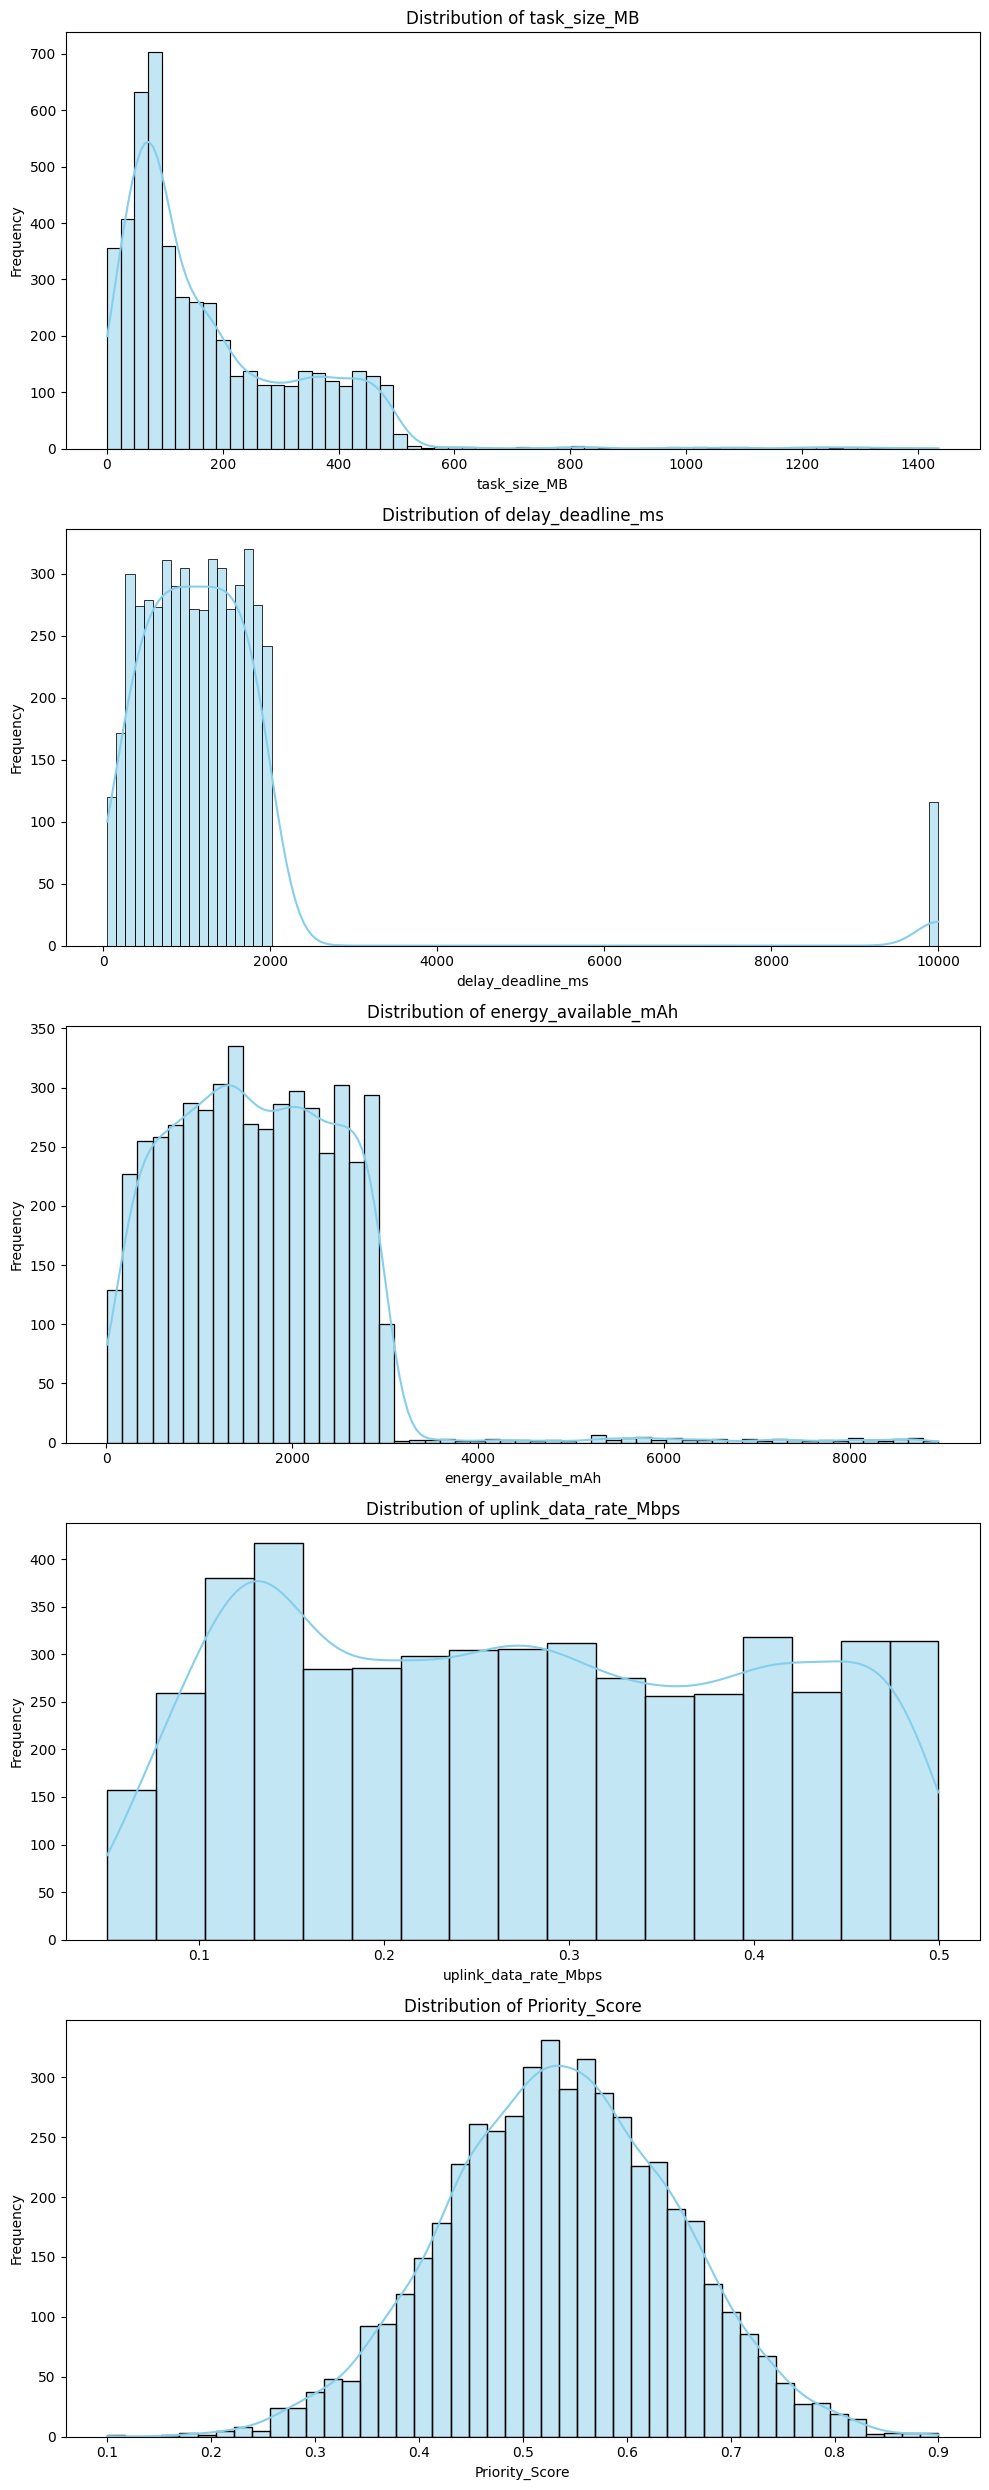

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to visualize
features_to_visualize = [
    'task_size_MB',
    'delay_deadline_ms',
    'energy_available_mAh',
    'uplink_data_rate_Mbps',
    'Priority_Score'
]

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=len(features_to_visualize), ncols=1, figsize=(10, 5 * len(features_to_visualize)))

# Flatten axes array for easy iteration if there's only one column of subplots
if len(features_to_visualize) == 1:
    axes = [axes]

# Generate a histogram for each feature
for i, feature in enumerate(features_to_visualize):
    sns.histplot(merged_df[feature], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust the layout to prevent overlaps
plt.tight_layout()
plt.show()


# UAV (AEC Servers with Capabilities) Dataset Generation

In [47]:
import pandas as pd
import numpy as np
import random

# --- Fix random seeds for reproducibility ---
seed = 42
np.random.seed(seed)
random.seed(seed)

# --------------------------------------------------------
# 10 Cluster Centroids (Lat, Lon)
# --------------------------------------------------------
cluster_centroids = [
    (23.746, 90.4345),   # Jatrabari
    (23.7465, 90.3716),  # Dhanmondi
    (23.78, 90.4167),    # Gulshan
    (23.725, 90.385),    # Azimpur
    (23.875, 90.3833),   # Uttara
    (23.805, 90.3583),   # Mirpur
    (23.7333, 90.4167),  # Motijheel
    (23.76, 90.3667),    # Lalmatia
    (23.79, 90.4067),    # Banani
    (23.7633, 90.3583)   # Mohammadpur
]

# --------------------------------------------------------
# Real Dhaka Area Names Mapped to Centroid Index
# --------------------------------------------------------
area_mapping = {
    1: "Jatrabari",
    2: "Dhanmondi",
    3: "Gulshan",
    4: "Azimpur",
    5: "Uttara",
    6: "Mirpur",
    7: "Motijheel",
    8: "Lalmatia",
    9: "Banani",
    10: "Mohammadpur"
}

# --------------------------------------------------------
# Function to Create Realistic UAV Attributes
# --------------------------------------------------------
def generate_uav_dataset():
    uav_data = []

    for idx, (lat, lon) in enumerate(cluster_centroids, start=1):

        # --------------------------
        # AREA MAPPING
        # --------------------------
        area_name = area_mapping[idx]

        # --------------------------
        # WEATHER-DRIVEN VARIABLES
        # --------------------------
        weather = "Thunderstorm"

        # Temperature depends on storm convection
        temperature = round(np.random.uniform(25, 32), 1)

        # High humidity during storm
        humidity = round(np.random.uniform(80, 100) - (32 - temperature) * 0.8, 1)
        humidity = max(min(humidity, 100), 75)

        # Strong wind in thunderstorm
        wind_speed = round(np.random.uniform(7, 18), 2)

        # Low visibility due to heavy rain & humidity
        visibility = round(np.random.uniform(1, 3.5) - (humidity - 75) * 0.01, 1)
        visibility = max(0.5, visibility)

        # Heavy rain intensity
        precipitation = round(np.random.uniform(15, 45), 1)

        # --------------------------
        # COMMUNICATION IMPACT MODEL
        # --------------------------
        base_uplink = np.random.uniform(25, 45)
        base_downlink = np.random.uniform(50, 80)

        rain_loss_factor = 1 - (precipitation / 120)
        visibility_loss = 1 - ((4 - visibility) / 10)
        wind_loss = 1 - (wind_speed / 60)

        channel_factor = rain_loss_factor * visibility_loss * wind_loss

        uplink_rate = round(max(2, base_uplink * channel_factor), 2)
        downlink_rate = round(max(5, base_downlink * channel_factor), 2)

        # --------------------------
        # UAV INFO (FINAL)
        # --------------------------
        uav_info = {
            "uav_id": f"U{idx}",
            "mec_uav_lat": lat,
            "mec_uav_lon": lon,

            # Real Area Name Assignment
            "mec_uav_area_name": area_name,

            # Hardware + Energy
            "mec_uav_cpu_GHz": round(np.random.uniform(0.8, 3.8), 2),
            "mec_uav_obstacle_distance_m": round(np.random.uniform(20, 180), 1),
            "mec_uav_remaining_energy_mAh": int(np.random.uniform(60000, 130000)),

            # Weather-linked Values
            "mec_uav_weather_condition": weather,
            "mec_uav_temperature_c": temperature,
            "mec_uav_humidity_pct": humidity,
            "mec_uav_wind_speed_mps": wind_speed,
            "mec_uav_visibility_km": visibility,
            "mec_uav_precipitation_mmh": precipitation,

            # Communication (after storm degradation)
            "bandwidth_MHz": round(np.random.uniform(5, 20), 2),
            "uplink_rate_Mbps": uplink_rate,
            "downlink_rate_Mbps": downlink_rate,

            # MEC Storage & RAM
            "aec_storage_GB": int(np.random.uniform(64, 512)),
            "aec_ram_GB": int(np.random.uniform(4, 32)),
        }

        uav_data.append(uav_info)

    return pd.DataFrame(uav_data)


# --------------------------------------------------------
# Generate Dataset
# --------------------------------------------------------
uav_df = generate_uav_dataset()

# --------------------------------------------------------
# Save Dataset to CSV
# --------------------------------------------------------
uav_df.to_csv("UAV_Capability_Dataset_for_iots.csv", index=False)

uav_df


,uav_id,mec_uav_lat,mec_uav_lon,mec_uav_area_name,mec_uav_cpu_GHz,mec_uav_obstacle_distance_m,mec_uav_remaining_energy_mAh,mec_uav_weather_condition,mec_uav_temperature_c,mec_uav_humidity_pct,mec_uav_wind_speed_mps,mec_uav_visibility_km,mec_uav_precipitation_mmh,bandwidth_MHz,uplink_rate_Mbps,downlink_rate_Mbps,aec_storage_GB,aec_ram_GB
0,U1,23.7460,90.4345,Jatrabari,3.40,116.2,109565,Thunderstorm,27.6,95.5,15.05,2.3,19.7,5.31,14.61,26.89,498,27
1,U2,23.7465,90.3716,Dhanmondi,2.64,42.3,80450,Thunderstorm,26.5,79.2,9.02,1.7,30.7,10.50,16.38,28.60,268,25
2,U3,23.7800,90.4167,Gulshan,3.65,174.5,116587,Thunderstorm,26.4,85.8,13.52,1.0,33.2,9.57,11.14,20.38,107,23
3,U4,23.7250,90.3850,Azimpur,1.74,103.2,98269,Thunderstorm,28.1,79.3,12.45,1.0,42.3,7.77,10.84,25.10,498,25
4,U5,23.8750,90.3833,Uttara,1.78,82.2,78994,Thunderstorm,31.6,97.6,13.58,3.1,17.7,17.43,17.36,30.82,223,11
5,U6,23.8050,90.3583,Mirpur,0.82,150.5,109480,Thunderstorm,28.8,80.3,15.82,1.1,44.6,15.94,13.29,18.38,409,6
6,U7,23.7333,90.4167,Motijheel,1.78,136.7,104629,Thunderstorm,27.5,78.7,16.49,2.5,24.9,18.31,12.83,28.98,275,7
7,U8,23.7600,90.3667,Lalmatia,0.88,37.3,62200,Thunderstorm,30.0,93.6,13.17,2.7,29.8,14.55,18.10,32.07,204,18
8,U9,23.7900,90.4067,Banani,1.28,168.8,116568,Thunderstorm,31.4,84.5,11.51,2.8,21.9,14.50,15.43,34.12,454,26
9,U10,23.7633,90.3583,Mohammadpur,1.48,88.3,117261,Thunderstorm,26.3,93.3,12.93,2.8,41.9,17.91,14.09,23.95,67,18


# Final AEC-IoT TaskNet Dataset for GLEMATO (MADDPG Algorithm) Framework

**Final AEC_IoT_TaskNet_Final_IoT_MEC_UAV_Dataset**

In [48]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, asin

# -------------------------------------------------------------------
# Load datasets (Modify file names if needed)
# -------------------------------------------------------------------
iot_df = merged_df                      # merged_iot_priority_dataset.csv already loaded as merged_df
uav_df = uav_df                         # Final_UAV_Capability_Dataset.csv already loaded as uav_df

# -------------------------------------------------------------------
# Define Haversine Formula for accurate geospatial distance (meters)
# -------------------------------------------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

# -------------------------------------------------------------------
# Find closest UAV for each IoT device
# -------------------------------------------------------------------
def find_closest_uav(iot_row, uav_df):
    min_distance = float('inf')
    closest_uav_id = None

    for index, uav_row in uav_df.iterrows():
        dist = haversine(
            iot_row['Location_Lat'], iot_row['Location_Lon'],
            uav_row['mec_uav_lat'], uav_row['mec_uav_lon']
        )
        if dist < min_distance:
            min_distance = dist
            closest_uav_id = uav_row['uav_id']

    return closest_uav_id

print("Calculating closest UAV for each IoT device...")
iot_df['closest_uav_id'] = iot_df.apply(lambda row: find_closest_uav(row, uav_df), axis=1)
print("Closest UAV calculation complete.")

# -------------------------------------------------------------------
# Merge IoT Dataset + UAV Dataset based on identified closest UAV ID
# -------------------------------------------------------------------
uav_df_renamed = uav_df.rename(columns={'uav_id': 'closest_uav_id'})

final_merged_df = pd.merge(
    iot_df,
    uav_df_renamed,
    on='closest_uav_id',
    how='left'
)

# -------------------------------------------------------------------
# Save final dataset
# -------------------------------------------------------------------
output_filename = "Final_AEC_IoT_TaskNet_Dataset_For_GLEMATO_AEC_IoT_.csv"
final_merged_df.to_csv(output_filename, index=False)

print(f"\nFinal merged dataset saved as '{output_filename}'")
print("\nPreview of the final merged dataset:")
final_merged_df


Calculating closest UAV for each IoT device...
Closest UAV calculation complete.

Final merged dataset saved as 'Final_AEC_IoT_TaskNet_Dataset_For_GLEMATO_AEC_IoT_.csv'

Preview of the final merged dataset:


,task_id,iot_id,task_type,task_size_MB,task_gen_time,cpu_frequency_GHz,cpu_cycles_per_bit,IPC,capability_MIPS,delay_deadline_ms,...,mec_uav_temperature_c,mec_uav_humidity_pct,mec_uav_wind_speed_mps,mec_uav_visibility_km,mec_uav_precipitation_mmh,bandwidth_MHz_y,uplink_rate_Mbps,downlink_rate_Mbps,aec_storage_GB,aec_ram_GB
0,T1384,D0,Sensor,85.78,2025-01-01 01:21:35,1.09,96278.37,0.68,741.2,1384,...,27.6,95.5,15.05,2.3,19.7,5.31,14.61,26.89,498,27
1,T1882,D0,Sensor,41.17,2025-01-01 11:51:25,0.55,182525.40,2.15,1182.5,1630,...,27.6,95.5,15.05,2.3,19.7,5.31,14.61,26.89,498,27
2,T4902,D0,AI,136.19,2025-01-01 03:25:29,1.18,81052.30,1.50,1770.0,877,...,27.6,95.5,15.05,2.3,19.7,5.31,14.61,26.89,498,27
3,T1525,D0,Sensor,36.18,2025-01-01 15:20:49,5.00,228063.02,2.41,939.9,10000,...,27.6,95.5,15.05,2.3,19.7,5.31,14.61,26.89,498,27
4,T4655,D0,Video,241.76,2025-01-01 09:48:18,1.81,62526.68,1.14,2063.4,1101,...,27.6,95.5,15.05,2.3,19.7,5.31,14.61,26.89,498,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,T1829,D526,Video,495.89,2025-01-01 06:22:21,1.96,58465.91,0.68,1332.8,1132,...,26.3,93.3,12.93,2.8,41.9,17.91,14.09,23.95,67,18
4996,T2007,D526,Video,454.43,2025-01-01 15:01:10,1.13,89721.06,1.87,2113.1,376,...,26.3,93.3,12.93,2.8,41.9,17.91,14.09,23.95,67,18
4997,T2254,D526,Video,228.03,2025-01-01 19:16:50,1.83,57288.97,2.48,4538.4,578,...,26.3,93.3,12.93,2.8,41.9,17.91,14.09,23.95,67,18
4998,T205,D526,AI,145.10,2025-01-01 23:49:53,0.80,113652.88,2.49,1992.0,1414,...,26.3,93.3,12.93,2.8,41.9,17.91,14.09,23.95,67,18


/tmp/ipython-input-65201248.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='task_type', ax=axes[0], palette='viridis')
/tmp/ipython-input-65201248.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='cluster_id', ax=axes[1], palette='plasma')


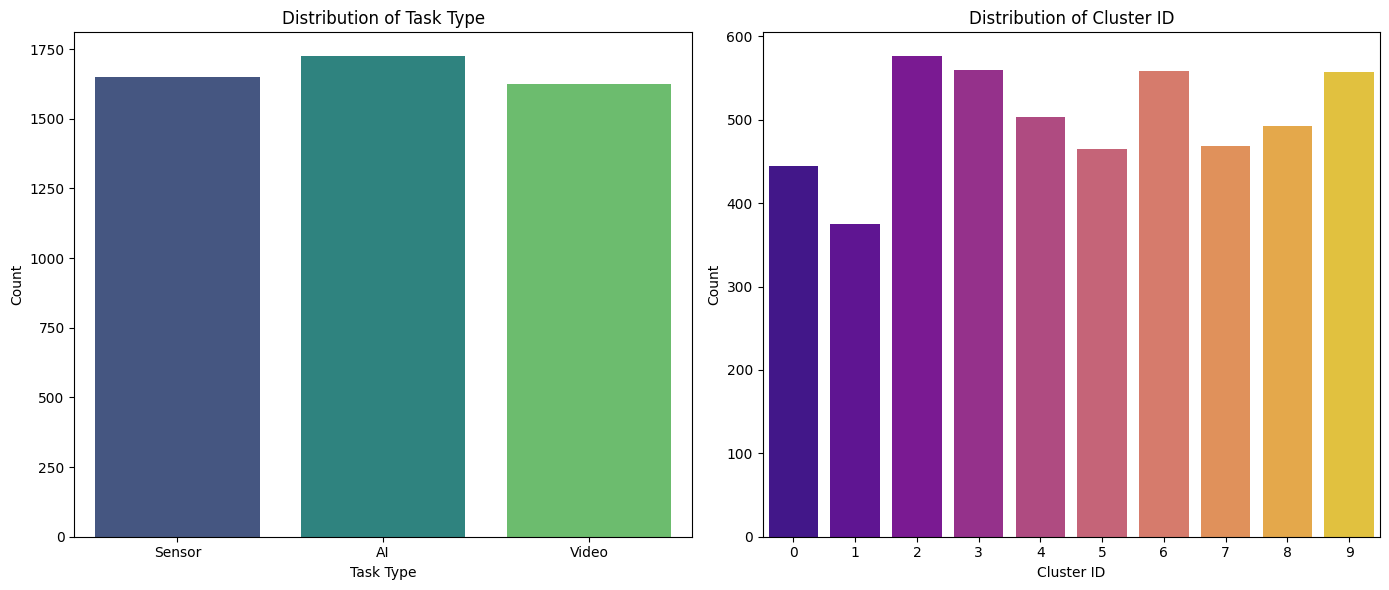

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Bar plot for 'task_type' distribution
sns.countplot(data=merged_df, x='task_type', ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Task Type')
axes[0].set_xlabel('Task Type')
axes[0].set_ylabel('Count')

# Bar plot for 'cluster_id' distribution
sns.countplot(data=merged_df, x='cluster_id', ax=axes[1], palette='plasma')
axes[1].set_title('Distribution of Cluster ID')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Count')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

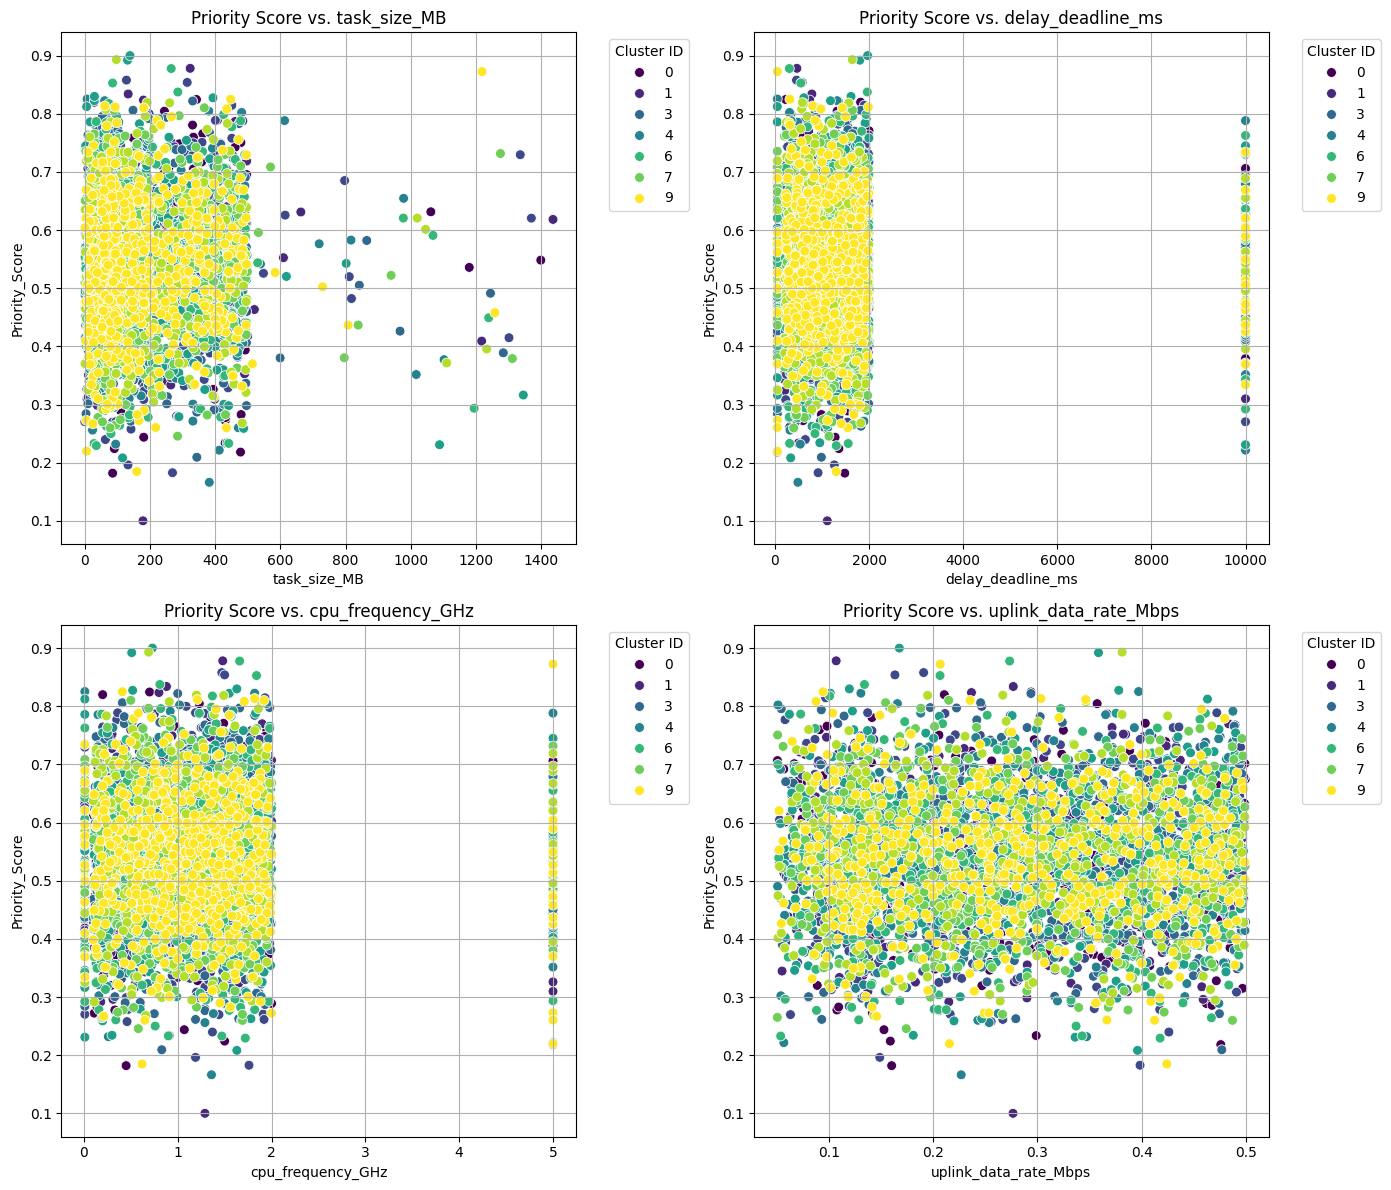

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features to plot against 'Priority_Score'
features_to_compare = [
    'task_size_MB',
    'delay_deadline_ms',
    'cpu_frequency_GHz',
    'uplink_data_rate_Mbps'
]

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.flatten() # Flatten the 2x2 array of axes for easier iteration

# Generate scatter plots for each feature comparison
for i, feature in enumerate(features_to_compare):
    sns.scatterplot(data=merged_df, x=feature, y='Priority_Score', ax=axes[i], hue='cluster_id', palette='viridis', s=50)
    axes[i].set_title(f'Priority Score vs. {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Priority_Score')
    axes[i].legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True)

# Adjust the layout to prevent overlaps
plt.tight_layout()
plt.show()

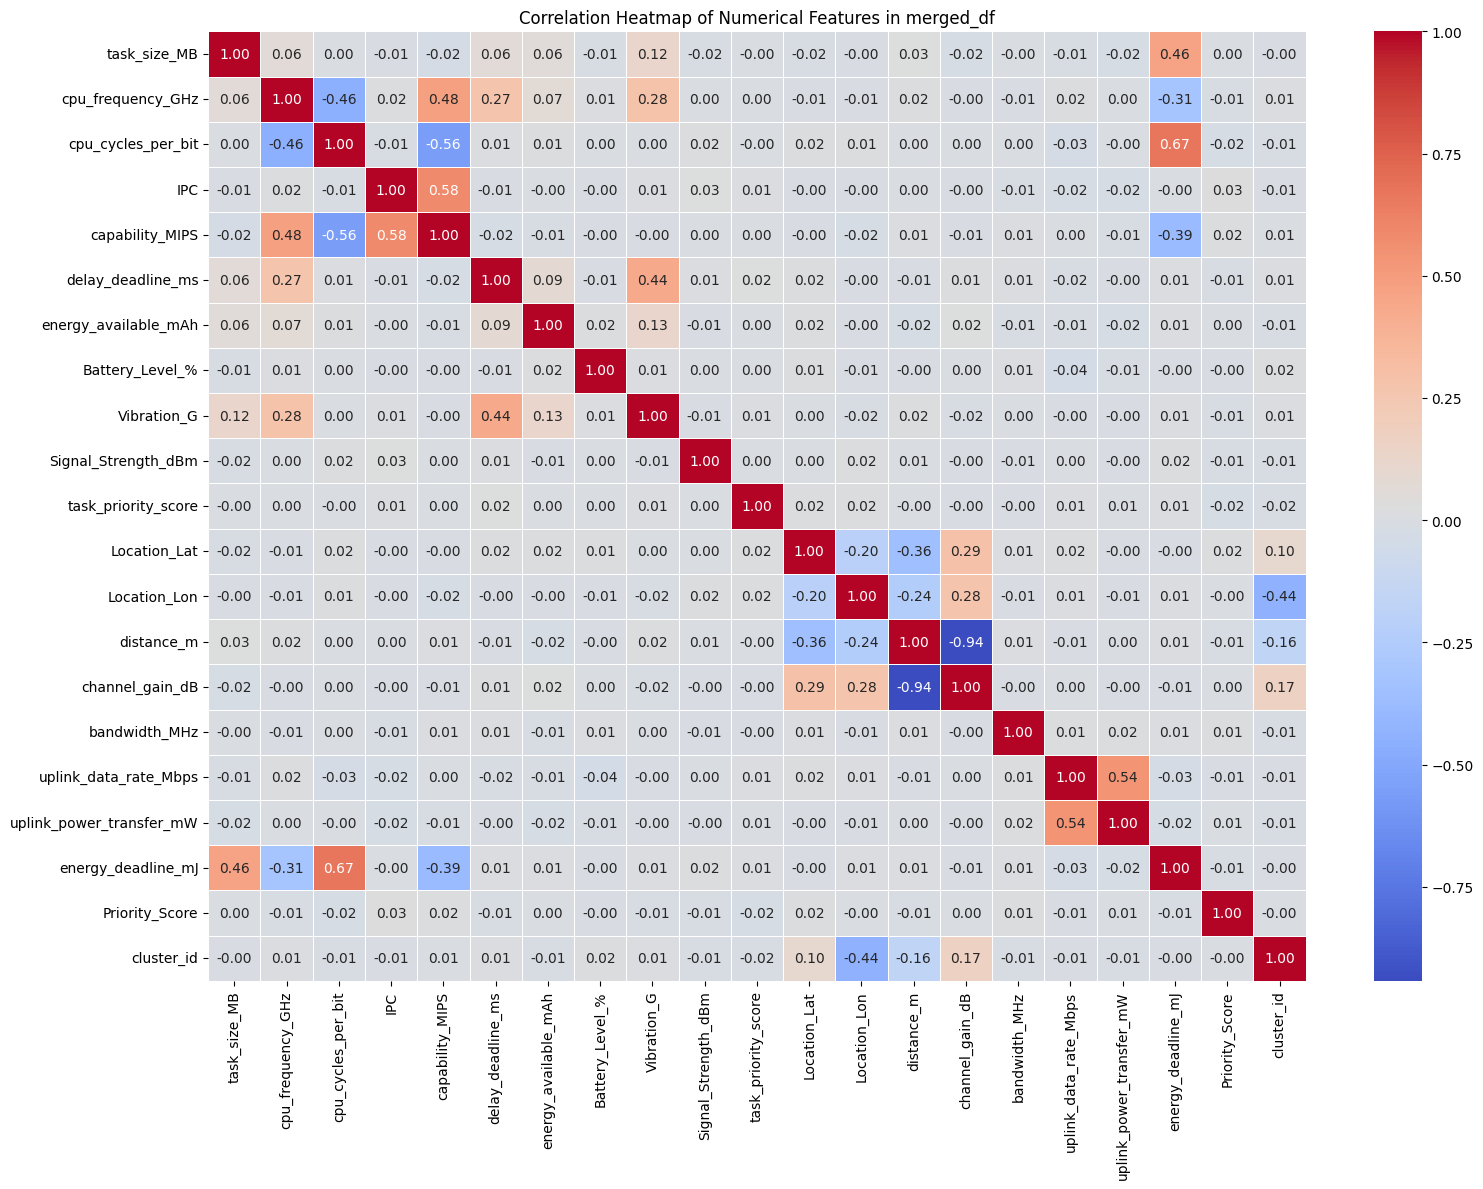

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for correlation heatmap
numerical_df = merged_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features in merged_df')
plt.tight_layout()
plt.show()


## Summary:

### Data Analysis Key Findings
*   A `closest_uav_id` column was successfully added to the `merged_df`, identifying the UAV geographically nearest to each IoT device based on Haversine distance calculations.
*   The initial `merged_df` was successfully merged with `uav_df` using a left join on the `closest_uav_id`, creating a comprehensive dataset named `final_merged_df`.
*   The final dataset, `GLEMETA_MADDPG_Final_IoT_MEC_UAV_Dataset.csv`, which integrates IoT device details with the characteristics of their closest UAVs, was successfully generated and saved.

### Insights or Next Steps
*   This dataset is foundational for further analysis of IoT device-UAV interactions, such as optimizing task offloading to the nearest MEC-enabled UAVs or analyzing network load distribution.
*   The geographical proximity data can be used to develop and evaluate algorithms for UAV deployment, dynamic resource allocation, or energy efficiency in IoT-MEC-UAV architectures.


# Final AEC-IoT TaskNet Dataset Validation Experiment

**Statistical Distribution Validation (Task Sizes, Deadlines, Rates, etc.)**

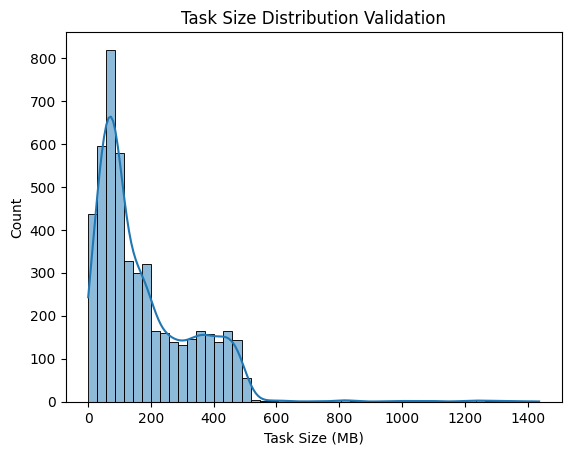

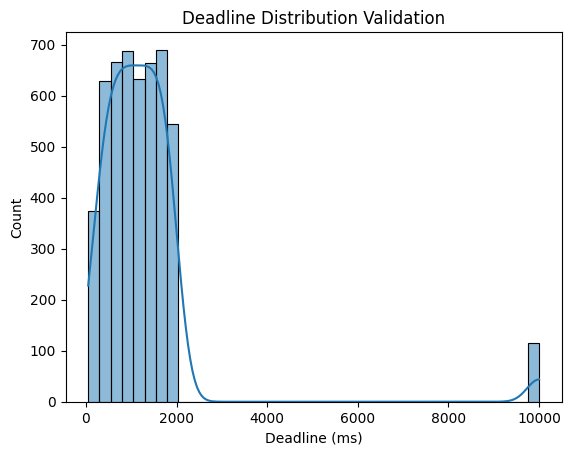

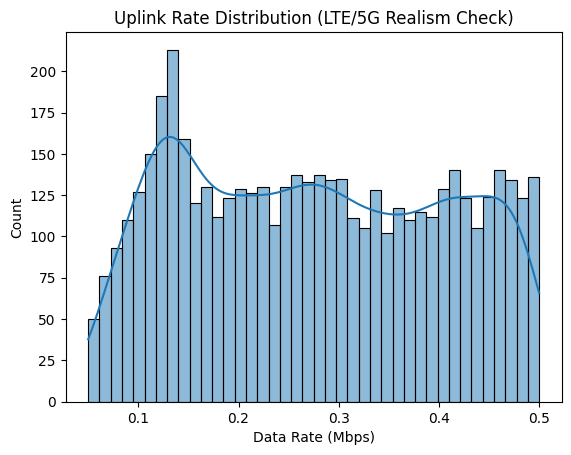

       task_size_MB  delay_deadline_ms  uplink_data_rate_Mbps
count   5000.000000         5000.00000            5000.000000
mean     179.981840         1287.15520               0.275866
std      161.642193         1444.12831               0.127722
min        0.546000           50.00000               0.050066
25%       65.622500          635.75000               0.159320
50%      122.195000         1101.00000               0.271703
75%      269.917500         1579.00000               0.389156
max     1436.130000        10000.00000               0.499854


In [30]:

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Distribution check for task sizes
sns.histplot(iot_df['task_size_MB'], bins=50, kde=True)
plt.title("Task Size Distribution Validation")
plt.xlabel("Task Size (MB)")
plt.show()

# 2. Deadline distribution check
sns.histplot(iot_df['delay_deadline_ms'], bins=40, kde=True)
plt.title("Deadline Distribution Validation")
plt.xlabel("Deadline (ms)")
plt.show()

# 3. Uplink data rate distribution
sns.histplot(iot_df['uplink_data_rate_Mbps'], bins=40, kde=True)
plt.title("Uplink Rate Distribution (LTE/5G Realism Check)")
plt.xlabel("Data Rate (Mbps)")
plt.show()

# Print summary statistics
print(iot_df[['task_size_MB','delay_deadline_ms','uplink_data_rate_Mbps']].describe())

**Spatial Clustering Validation (Dhaka city density realism)**

**2D Analysis**

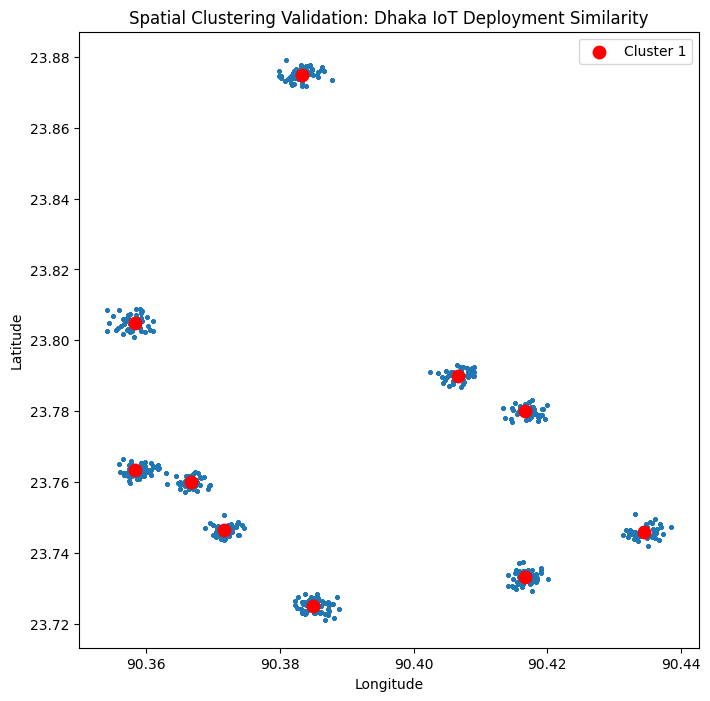

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(iot_df['Location_Lon'], iot_df['Location_Lat'], s=5, alpha=0.5)
for idx, center in enumerate(area_centers):
    plt.scatter(center[1], center[0], c='red', s=80, label=f'Cluster {idx+1}' if idx==0 else "")

plt.title("Spatial Clustering Validation: Dhaka IoT Deployment Similarity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

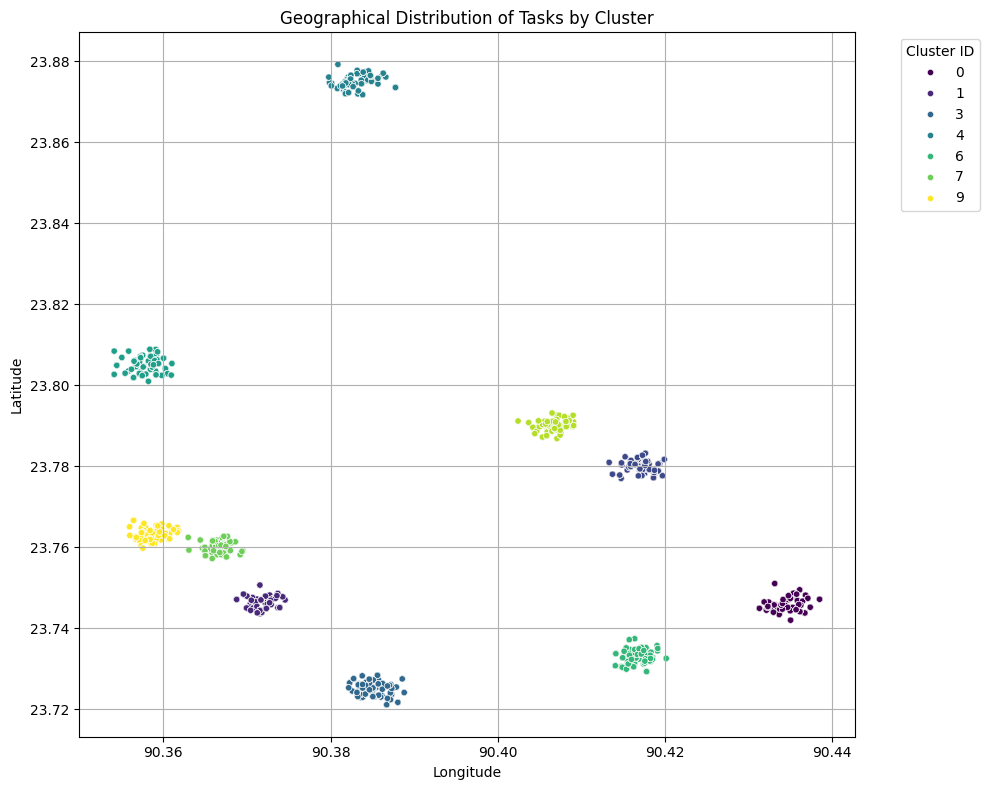

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_df, x='Location_Lon', y='Location_Lat', hue='cluster_id', palette='viridis', s=20)
plt.title('Geographical Distribution of Tasks by Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**3D Cluster Analysis with Airship**

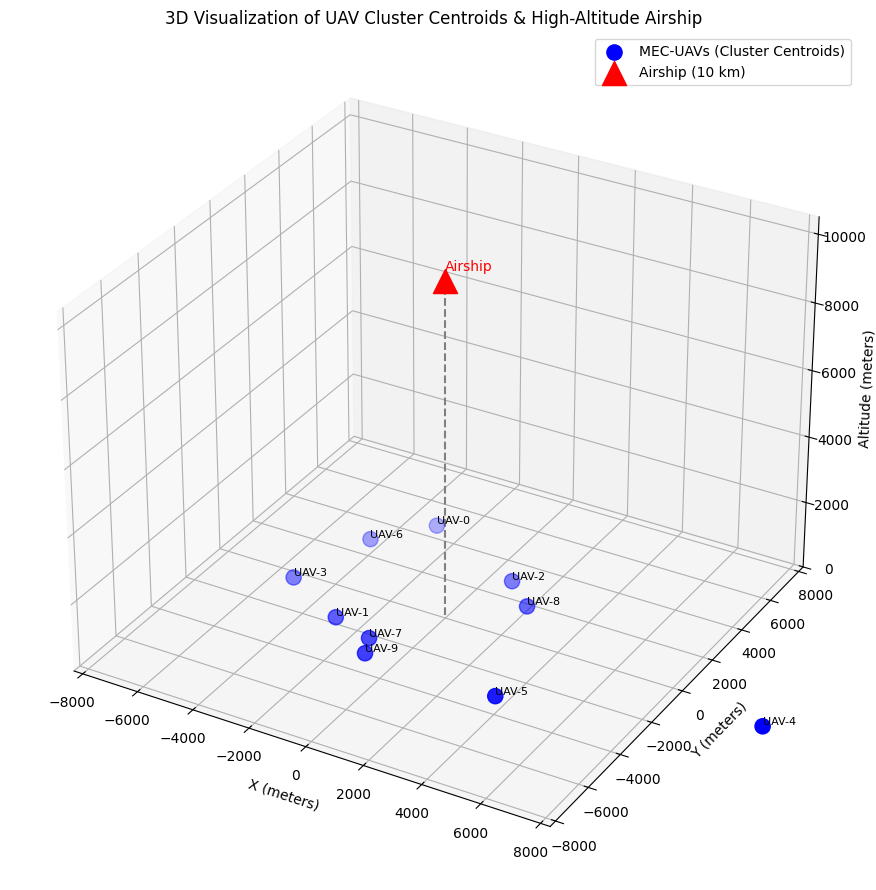

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------------------------
# LOAD DATASET
# -------------------------------------------------
df = pd.read_csv("Final_AEC_IoT_TaskNet_Dataset_For_GLEMATO_AEC_IoT_.csv")

# -------------------------------------------------
# COMPUTE UAV LOCATIONS = CLUSTER CENTROIDS
# -------------------------------------------------
# Get unique IoT devices with their lat/lon
centroids = df.groupby('iot_id').first().reset_index()
centroids = centroids[['iot_id', 'Location_Lat', 'Location_Lon']]

# Map cluster IDs (you MUST supply iot_devices: same object you used during dataset generation)
device_cluster_map = {dev['iot_id']: dev['cluster_id'] for dev in iot_devices}
centroids['cluster_id'] = centroids['iot_id'].map(device_cluster_map)

# Compute per-cluster centroid
uav_locations = centroids.groupby('cluster_id')[['Location_Lat', 'Location_Lon']].mean().reset_index()

# Rename for clarity
uav_locations.rename(columns={
    'Location_Lat': 'mec_uav_lat',
    'Location_Lon': 'mec_uav_lon'
}, inplace=True)

# Add altitude
uav_locations['Altitude_m'] = 100

# -------------------------------------------------
# CONVERT LAT/LON TO CARTESIAN METERS
# -------------------------------------------------
LAT_TO_M = 111000
mid_lat = uav_locations['mec_uav_lat'].mean()
LON_TO_M = 111000 * np.cos(np.radians(mid_lat))

uav_locations['x_m'] = (uav_locations['mec_uav_lat'] -
                        uav_locations['mec_uav_lat'].mean()) * LAT_TO_M

uav_locations['y_m'] = (uav_locations['mec_uav_lon'] -
                        uav_locations['mec_uav_lon'].mean()) * LON_TO_M

uav_locations['z_m'] = uav_locations['Altitude_m']

# -------------------------------------------------
# COMPUTE AIRSHIP POSITION
# -------------------------------------------------
airship_x = uav_locations['x_m'].mean()
airship_y = uav_locations['y_m'].mean()
airship_z = 10000  # 10 km

# -------------------------------------------------
# CREATE 3D PLOT
# -------------------------------------------------
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot UAVs
ax.scatter(
    uav_locations['x_m'], uav_locations['y_m'], uav_locations['z_m'],
    c='blue', s=120, marker='o', label='MEC-UAVs (Cluster Centroids)'
)

# Annotate UAV IDs (cluster IDs)
for i, row in uav_locations.iterrows():
    ax.text(
        row['x_m'], row['y_m'], row['z_m'] + 40,
        f"UAV-{int(row['cluster_id'])}",
        fontsize=8, color='black'
    )

# Plot Airship
ax.scatter(
    [airship_x], [airship_y], [airship_z],
    c='red', s=300, marker='^', label='Airship (10 km)'
)
ax.text(airship_x, airship_y, airship_z + 300,
        'Airship', fontsize=10, color='red')

# Draw vertical dashed link between UAV field and Airship
ax.plot(
    [airship_x, airship_x],
    [airship_y, airship_y],
    [100, airship_z],
    linestyle='--', color='gray'
)

# -------------------------------------------------
# LABELS & STYLE
# -------------------------------------------------
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_zlabel('Altitude (meters)')
ax.set_title('3D Visualization of UAV Cluster Centroids & High-Altitude Airship')

ax.legend()
plt.tight_layout()

# Scale all axes equally
max_range = np.array([
    uav_locations['x_m'].max() - uav_locations['x_m'].min(),
    uav_locations['y_m'].max() - uav_locations['y_m'].min(),
    airship_z
]).max() / 2

ax.set_xlim(airship_x - max_range, airship_x + max_range)
ax.set_ylim(airship_y - max_range, airship_y + max_range)
ax.set_zlim(0, airship_z + 500)

plt.show()